/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


vocab.txt:   0%|          | 0.00/879k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


model.safetensors:   0%|          | 0.00/836M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Train Loss: 0.5900, Train Accuracy: 0.6883, Val Loss: 0.5061, Val Accuracy: 0.7745
Best model saved!
Epoch 2/5, Train Loss: 0.4663, Train Accuracy: 0.7829, Val Loss: 0.4305, Val Accuracy: 0.8028
Best model saved!
Epoch 3/5, Train Loss: 0.4205, Train Accuracy: 0.8093, Val Loss: 0.4032, Val Accuracy: 0.8129
Best model saved!
Epoch 4/5, Train Loss: 0.4021, Train Accuracy: 0.8186, Val Loss: 0.4059, Val Accuracy: 0.8103
No improvement, not saving the model.
Epoch 5/5, Train Loss: 0.3851, Train Accuracy: 0.8274, Val Loss: 0.3955, Val Accuracy: 0.8152
Best model saved!
Test Loss: 0.4166, Test Accuracy: 0.8059


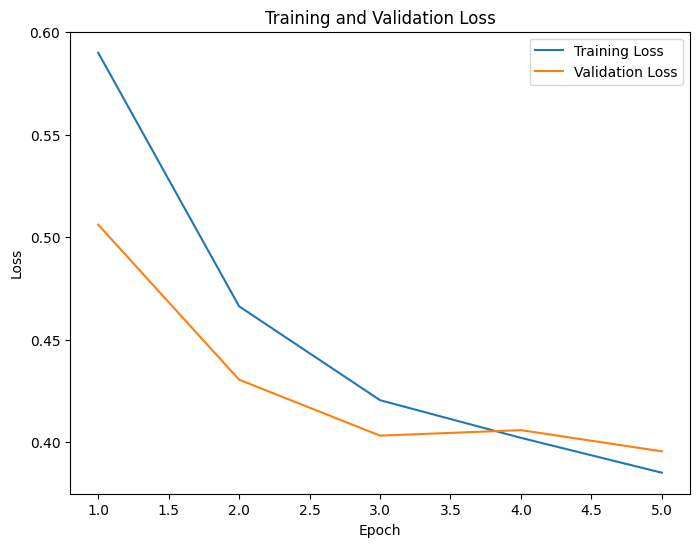

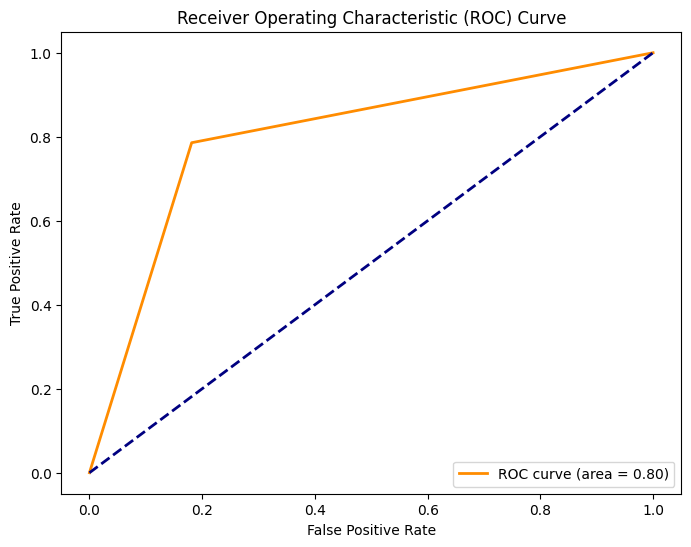

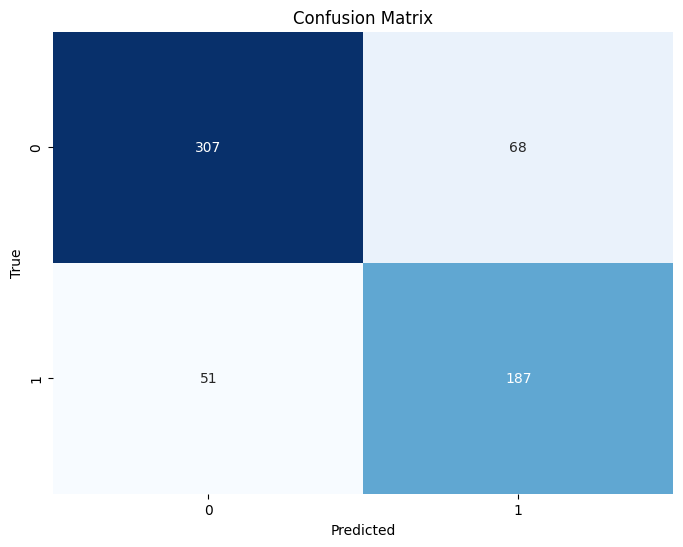

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, f1_score, mean_squared_error, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython import get_ipython
from IPython.display import display

# Load data (Assuming this part is already correct from previous cells)
df = pd.read_csv("/content/drive/MyDrive/Moroccan_Darija_Offensive_Language_Detection_Dataset.csv")
X = list(df["text"])
y = list(df["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.15, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "SI2M-Lab/DarijaBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def encode_bert(texts, max_length):
  input_ids = []
  attention_masks = []

  for text in texts:
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )
    input_ids.append(encoded["input_ids"])
    attention_masks.append(encoded["attention_mask"])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)

  return input_ids, attention_masks

max_length = 128
train_bert_encodings = encode_bert(X_train, max_length)
val_bert_encodings = encode_bert(X_val, max_length)
test_bert_encodings = encode_bert(X_test, max_length)

train_dataset = TensorDataset(train_bert_encodings[0], train_bert_encodings[1], torch.tensor(y_train))
val_dataset = TensorDataset(val_bert_encodings[0], val_bert_encodings[1], torch.tensor(y_val))
test_dataset = TensorDataset(test_bert_encodings[0], test_bert_encodings[1], torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class DarijaBERTBiLSTM(nn.Module):
    def __init__(self, bert_model):
        super(DarijaBERTBiLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(
            input_size=bert_model.config.hidden_size,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            batch_first=True
            )
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            best_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            bert_sequence_output = best_outputs.last_hidden_state
        lstm_out, _ = self.lstm(bert_sequence_output)
        max_pool, _ = torch.max(lstm_out, 1)

        # Defense layers
        x = self.relu(self.fc1(max_pool))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        return x

model = DarijaBERTBiLSTM(model)
model = model.to(device)

criterion = nn.BCELoss() # Corrected typo
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# Train loop
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels.unsqueeze(1))
        total_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_predictions += (preds == labels.unsqueeze(1)).sum().item()

        loss.backward()
        optimizer.step()

    return total_loss / len(data_loader), correct_predictions / len(data_loader.dataset)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in data_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.float().to(device)

            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels.unsqueeze(1))
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(data_loader), accuracy_score(all_labels, all_preds), all_preds, all_labels

num_epochs = 5
best_val_loss = float('inf')

# Lists to store loss and accuracy per epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device) # Don't need predictions for validation evaluation loop

    # Append loss and accuracy to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")
    else:
        print("No improvement, not saving the model.")

# Load the best model before evaluating on the test set
model.load_state_dict(torch.load("best_model.pth"))

# Evaluate on test set and get predictions and true labels
test_loss, test_accuracy, y_pred, y_true = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Convert y_true and y_pred to numpy arrays for scikit-learn metrics
y_true = [int(label) for label in y_true] # Ensure labels are integers
y_pred = [int(pred[0]) for pred in y_pred] # Ensure predictions are integers and flatten list

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Calculate and plot evaluation metrics using collected test predictions
f1 = f1_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Plot ROC-Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()